In [1]:
from rdflib import Graph
from rdflib.namespace import RDF, OWL
from rdflib.term import BNode
from cmatcher.owl_utils import load_entities, load_cqas, load_sg, add_depth, to_pyg
from tqdm.auto import tqdm
from torch.utils.data import DataLoader as TorchDataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import degree
from torch_geometric.loader import DataLoader
from cmatcher.cqa_search import *
from torch_geometric.nn import MessagePassing
from cmatcher.eval_utils import prepare_eval_dataset, embed_cqas, embed_subg, eval_metrics
from transformers import AutoTokenizer, BertModel, DistilBertModel, AutoModel
import transformers.optimization as toptim
import torch.utils.checkpoint as checkpoint
import dill
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import time
import copy
import torch_geometric.nn as gnn
from torch_scatter import scatter_sum
from accelerate import Accelerator, notebook_launcher
import random

torch.manual_seed(0)
random.seed(0)

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
paths = {
    'edas.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/edas.owl',
    'ekaw.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/ekaw.owl',
    'confOf.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/confOf.owl',
    'conference.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/Conference.owl',
    'cmt.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/cmt.owl',
}

cqa_path = '/projets/melodi/gsantoss/data/complex/CQAs'
entities_path = '/projets/melodi/gsantoss/data/complex/entities-cqas'

In [4]:
if os.path.exists('/projets/melodi/gsantoss/tmp/idata.pkl'):
    with open('/projets/melodi/gsantoss/tmp/idata.pkl', 'rb') as f:
        idata = dill.load(f)
        print('loaded from cache.')
else:
    with open('/projets/melodi/gsantoss/tmp/idata.pkl', 'wb') as f:
        dill.dump(load_entities(entities_path, paths), f)

isg = load_sg(entities_path, paths)

cqas = load_cqas(cqa_path)
raw_data = build_raw_data(idata, cqas)


loaded from cache.


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
# tokenizer = AutoTokenizer.from_pretrained("roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("razent/spbert-mlm-base")

In [6]:



if os.path.exists('/projets/melodi/gsantoss/tmp/edas.pkl'):
    with open('/projets/melodi/gsantoss/tmp/edas.pkl', 'rb') as f:
        ifd, mc, mp, fres = dill.load(f)
        print('loaded from cache.')
else:
    ifd, mc, mp, fres = build_raw_ts('/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/edas.owl', isg['edas'],
                                    workers=6)
    with open('/projets/melodi/gsantoss/tmp/edas.pkl', 'wb') as f:
        dill.dump((ifd, mc, mp, fres), f)


loaded from cache.


In [7]:
cidata = copy.deepcopy(idata)
del cidata['edas']

In [8]:
def prepare_eval_dataset(data, ifd, tokenizer, mc, mp, fres, filter_bn=True):
    ts = []
    graph_data = []
    for s, cm, pm, fm in tqdm(ifd):
        pd1, pdi1 = pad_entities(tokenizer, cm, mc)

        pd3, pdi3 = pad_entities(tokenizer, pm, mp)

        edge1 = torch.LongTensor(fm)

        ts.append(s)
        graph_data.append(GraphData(
            rsi=torch.LongTensor([0]),
            x_s=pdi1.long(),
            x_sf=pd1.long(),
            edge_index_s=edge1.long(),
            edge_feat_s=pdi3.long(),
            edge_feat_sf=pd3.long(),
        ))


    cq = []
    cqi = []
    for k in data:
        if filter_bn and type(fres[k]) is BNode:
            fres.pop(k, None)
            continue

        cq.append(k)
        cqi.append(data[k])

    cqid = tokenizer(cqi, return_tensors='pt', padding=True)['input_ids']

    return ts, graph_data, cq, cqid




In [9]:
root_entities, graph_data, cq, cqid = prepare_eval_dataset(cqas['edas'], ifd, tokenizer, mc, mp, fres, filter_bn=True)


  0%|          | 0/524 [00:00<?, ?it/s]

In [19]:

class GNNL(gnn.MessagePassing):
    def __init__(self, d_model, num_heads, drop=0.1):
        super(GNNL, self).__init__(aggr='add')
        self.d_model = d_model
        self.num_heads = num_heads
        
        self.ck = nn.Linear(2 * d_model, d_model)
        
        self.qw = nn.Linear(d_model, d_model)
        self.vw = nn.Linear(d_model, d_model)

        self.aw = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Linear(num_heads, num_heads)
        )

        self.drop = nn.Dropout(drop)

        self.cw = nn.Linear(d_model, d_model)

        self.lx = nn.Linear(d_model, d_model)
        
        self.la = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.LeakyReLU(0.2),
            nn.Linear(d_model, 2),
            nn.Softmax(dim=1),
            nn.Dropout(drop)
        )


    def forward(self, x, edge_index, edge_attr):
        
        q = self.qw(x[edge_index[1]])
        k = self.ck(torch.cat([edge_attr, x[edge_index[0]]], dim=1))
        
        attention = self._attention(q, k, edge_index, x.shape[0]).unsqueeze(-1)
        
        h = self.propagate(edge_index, x=x, edge_attr=edge_attr, attention=attention)
        
        lx = self.lx(x)
        
        la = self.la(torch.cat([lx, h], dim=1))
        
        return x * la[:, 0].unsqueeze(-1) + h * la[:, 1].unsqueeze(-1)
    
    def _attention(self, q, k, ei, n):
        
        wq = self._reshape_mh(q)
        wk = self._reshape_mh(k)
        
        aw = torch.einsum('bhd,bhq->bh', wq, wk) / math.sqrt(self.d_model)
        a = torch.exp(self.aw(aw))
        
        sc = scatter_sum(a, ei[1], dim=0, dim_size=n)
        
        ad = sc[ei[1]]
        ad[ad == 0] = 1
        
        return self.drop(a / ad)


    def message(self, x_i, x_j, edge_attr, attention):
        
        v = self.vw(x_j)

        wv = self._reshape_mh(v)
    
        fw = attention * wv
        
        return self.cw(self._reshape_out(fw))
    
    
    def _reshape_mh(self, x):
        return x.view(x.shape[0], self.num_heads, -1)

    def _reshape_out(self, x):
        return x.reshape(x.shape[0], self.d_model)
    
    
    
class GNN(nn.Module):
    def __init__(self, d_model, num_heads, drop=0.1, d=3):
        super(GNN, self).__init__()
        self.gnns = nn.ModuleList([GNNL(d_model, num_heads, drop) for _ in range(d)])

    def forward(self, x, edge_index, edge_attr):
        for g in self.gnns:
            x = g(x, edge_index, edge_attr)
        return x
    
    
edge_index = torch.tensor([[0, 1, 2],
                           [1, 1, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0.5], [-1]], dtype=torch.float)

#torch.Size([70, 768]) torch.Size([2, 195]) torch.Size([195, 768])
data = Data(x=x, edge_index=edge_index, edge_attr=torch.ones((2, 1)))

g = GNNL(768, 4)

out = g(torch.randn(70, 768), torch.randint(0, 70, (2, 195)), torch.randn(195, 768))
# out = g(x, edge_index, torch.ones((2, 1)))
# print(out)
print(out.shape)


torch.Size([70, 768])


In [20]:
    
    
class BertEmb(nn.Module):
    def __init__(self):
        super(BertEmb, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.bert = BertModel.from_pretrained('bert-large-uncased')
        # self.bert = AutoModel.from_pretrained("roberta-base")
        # self.bert = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")
        # self.bert = AutoModel.from_pretrained("roberta-large")
        # self.bert = AutoModel.from_pretrained("razent/spbert-mlm-base")
        self.bert.pooler.requires_grad_(False)
        # self.bert.gradient_checkpointing_enable()
    def forward(self, x):
        mask = x > 0
        out = self.bert(input_ids=x, attention_mask=mask)['last_hidden_state']

        om = mask.unsqueeze(-1).float()

        mo = out * om
        cf = om.sum(dim=1)
        cf[cf == 0] = 1
        return mo.sum(dim=1) / cf


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.emb1 = BertEmb()
        self.gnn = GNN(768, 8, d=1)


    def forward(self, cqa=None, positive_sbg=None, negative_sbg=None):
        
        if cqa is not None:
            cqa = self.embed_cqa(cqa)

        sbg = None
        
        if positive_sbg is not None:
            x, xi, edge_index, edge_attr, edge_attr_i = positive_sbg

            sbg = self.embed_subg(x, xi, edge_index, edge_attr, edge_attr_i)
        nsbg = None
        
        if negative_sbg is not None:
            nx, nxi, nedge_index, nedge_attr, nedge_attr_i = negative_sbg
            nsbg = self.embed_subg(nx, nxi, nedge_index, nedge_attr, nedge_attr_i)

        return cqa, sbg, nsbg

    def embed_cqa(self, x):
        return self.emb1(x)

    def embed_subg(self, x, xi, edge_index, edge_attr, edge_attr_i):
        feats = []
        for f in TorchDataLoader(x, batch_size=4, shuffle=False):
            feats.append(checkpoint.checkpoint(self.emb1, f, use_reentrant=False))
        feats = torch.cat(feats, dim=0)
        sf = feats[xi]
        
        props = []
        for f in TorchDataLoader(edge_attr, batch_size=4, shuffle=False):
            props.append(checkpoint.checkpoint(self.emb1, f, use_reentrant=False))
        props = torch.cat(props, dim=0)
        edge_attr_sf = props[edge_attr_i]

        out = checkpoint.checkpoint(self.gnn, sf, edge_index, edge_attr_sf, use_reentrant=False)
        return out


model = Model()
device = torch.device('cuda:0')
# model.cuda(0)

Launching training on 2 GPUs.


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


  0%|          | 0/156 [00:00<?, ?it/s]

First evaluation:
bt: 0.75 avgp: 0.12, rec: 0.05, afm: 0.07
ev data: 0.00
bt: 0.90 avgp: 0.81, rec: 0.05, afm: 0.10
epoch 0 loss: 0.34, ev: 0.05
bt: 0.80 avgp: 0.53, rec: 0.84, afm: 0.65
epoch 1 loss: 0.25, ev: 0.55
bt: 0.70 avgp: 0.63, rec: 1.00, afm: 0.77
epoch 2 loss: 0.16, ev: 0.75
bt: 0.80 avgp: 0.69, rec: 1.00, afm: 0.81
epoch 3 loss: 0.11, ev: 0.97


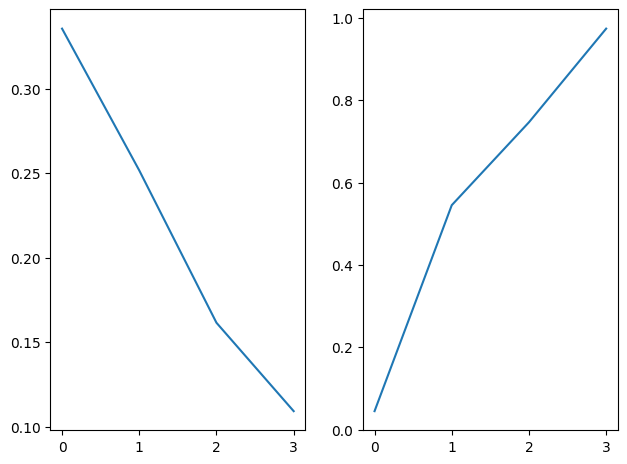

In [21]:
def sim_loss(cq, pe, ne):
    return torch.mean(1 - torch.cosine_similarity(cq, pe) + torch.cosine_similarity(cq, ne))

def evm(accelerator, model, dataset, th=0.5):
    model.eval()

    res = []
    for batch in DataLoader(dataset, batch_size=2):
        with torch.no_grad():

            cqs, sbgs, _ = model(cqa=batch.cqs, positive_sbg=(batch.x_sf, batch.x_s,
                              batch.edge_index_s, batch.edge_feat_sf, batch.edge_feat_s))

            isbgs = sbgs[batch.rsi]

            sim = torch.cosine_similarity(cqs, isbgs) > th
            res.append(accelerator.gather_for_metrics(sim))
            

    res = torch.cat(res, dim=0)

    return (res.sum() / res.size(0)).item()


def eval_test(accelerator, model, cqloader, graph_loader, cq, root_entities, res):
    model.eval()

    cqeb = embed_cqas(accelerator, model, cqloader)
    graph_embeddings = embed_subg(accelerator, model, graph_loader)

    if accelerator.is_main_process:
        avgps = []
        rcs = []
        fms = []
    
        for t in torch.arange(0, 1, 0.05):
            avgp, rc, fm = eval_metrics(cq, cqeb, graph_embeddings, root_entities, res, th=t)
            avgps.append(avgp)
            rcs.append(rc)
            fms.append(fm)
    
        bv = torch.tensor(fms).argmax().item()
        accelerator.print(f'bt: {bv * 0.05:.2f} avgp: {avgps[bv]:.2f}, rec: {rcs[bv]:.2f}, afm: {fms[bv]:.2f}')


def train_function(model, root_entities, graph_data, cq, cqid, res):

    # accelerator = Accelerator(gradient_accumulation_steps=4)
    accelerator = Accelerator()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    # optimizer = toptim.Adafactor(model.parameters())
    
    lh = []
    evh = []
    epochs = 4
    batch_size = 2
    progress = None
    
    triplet_loss = nn.TripletMarginWithDistanceLoss(
         distance_function=lambda x, y: 1.0 - torch.cosine_similarity(x, y), margin=0.8)
    
    dataset = CQADataset(tokenizer, cidata, raw_data['edas'], filter_bn=True)
    loader = DataLoader(dataset, batch_size=batch_size)
    
    
    cqloader = DataLoader(cqid, batch_size=batch_size, shuffle=False)
    graph_loader = DataLoader(graph_data, batch_size=batch_size, shuffle=False)
    
    model, optimizer, loader, cqloader, graph_loader = accelerator.prepare(model, optimizer, loader, cqloader, graph_loader)
    
    model.find_unused_parameters = False
    if not progress and accelerator.is_main_process:
        progress = tqdm(total=epochs * len(loader))

    accelerator.print('First evaluation:')
    eval_test(accelerator, model, cqloader, graph_loader, cq, root_entities, res)
    accelerator.print(f'ev data: {evm(accelerator, model, dataset, th=0.9):.2f}')
    
    for e in range(epochs):
    
        model.train()
        
        el = []
        for batch in loader:
            with accelerator.accumulate(model):
                optimizer.zero_grad()
                

                
                cqs, sbgs, nsbg = model(cqa=batch.cqs, positive_sbg=(batch.x_sf, batch.x_s,
                              batch.edge_index_s, batch.edge_feat_sf, batch.edge_feat_s), negative_sbg=(batch.x_nf, batch.x_n,
                               batch.edge_index_n, batch.edge_feat_nf, batch.edge_feat_n))
                    

                isbgs = sbgs[batch.rsi]
                isbgn = nsbg[batch.rni]
        
                # loss = sim_loss(cqs, isbgs, isbgn)
                loss = triplet_loss(cqs, isbgs, isbgn)
                el.append(accelerator.gather_for_metrics(loss.detach()))
                accelerator.backward(loss)
        
                optimizer.step()
                if accelerator.is_main_process:
                    progress.update(1)
                
        lh.append(torch.stack(el).mean().item())

        evh.append(evm(accelerator, model, dataset, th=0.9))
        eval_test(accelerator, model, cqloader, graph_loader, cq, root_entities, res)
        accelerator.print(f'epoch {e} loss: {lh[-1]:.2f}, ev: {evh[-1]:.2f}')
    
    
    if accelerator.is_main_process:
        progress.close()
    
        fig, ax = plt.subplots(1, 2)
        fig.tight_layout()
        ax[0].plot(lh)
        ax[1].plot(evh)
        plt.show()

notebook_launcher(train_function, (model, root_entities, graph_data, cq, cqid, fres), num_processes=2, use_port='29502')